## Getting Real Estate Data Using Python

In this post, I'll present the quickest way to get up and running fast, doing analysis on real estate data using Python.  We'll make a request to the [OpenHouse](http://openhouseproject.co) API, retrieve some data, and then do a quick analysis.  You won't need any prior experience beyond basic Python to follow this walkthrough.

In [28]:
%matplotlib inline
import matplotlib.pyplot as plt
import requests
import json
import pandas as pd

The url below makes a specific request to the OpenHouse API.  If you look through it, you can see the parameters being used and perhaps edit them to suit your own needs.  If you check out the [OpenHouse gallery](http://gallery.openhouseproject.co), you can use a user interface to customize this request.

In [2]:
url = "http://api.openhouseproject.co/api/property/?min_price=0&max_price=5000000&min_bedrooms=0&max_bedrooms=8&min_bathrooms=0&max_bathrooms=7&min_building_size=100&max_building_size=4000&close_to=(158.58473030020312,33.99802726234877,-118.223876953125)"

Let's retrieve the data and confirm that the server sent us a good response (i.e. status code is 200).

In [4]:
r = requests.get(url)
r.status_code == 200

True

The results come back from the API as a list of bytes in the [UTF-8 format](https://en.wikipedia.org/wiki/UTF-8).  Let's decode that and convert it to a [JSON](https://www.w3schools.com/js/js_json_intro.asp) object.  If you're not already familiar with JSON, you should stop and check out the previous link to learn about it.  People with basic Python experience should find it very intuitive and straightforward.

In [10]:
response = json.loads(r.content.decode("utf-8"))
print(response.keys())

dict_keys(['count', 'previous', 'next', 'results'])


The response is a dictionary that has four keys.

The *count* value is the number of records returned

The *previous* and *next* values are useful for paginating through the data if there are more results available than what you retrieved.  We won't be using those in this post.

Finally *results* is the most interesting part to us.  It's a list of property details.  Let's print out one as an example and see what it contains.

In [16]:
home = response['results'][0]
for key in home.keys():
    if key not in ('raw_address', 'address_object', 'valid', 'submitter'):
        print(key + ":")
        print(home[key])
        print("-------------")

land_size:
None
-------------
building_size:
761.0
-------------
price:
1000000.0
-------------
bathrooms:
1.0
-------------
upload_timestamp:
2016-06-23T02:10:28.006187Z
-------------
size_units:
I
-------------
listing_type:
S
-------------
id:
55118
-------------
bedrooms:
1.0
-------------
listing_timestamp:
2016-02-17T00:00:00Z
-------------
features:
[]
-------------
car_spaces:
None
-------------


I left out the `address_object` because it's large and worth unpacking itself.

In [19]:
keys = home['address_object'].keys()
for key in keys:
    if key != 'raw':
        print(key + ":")
        print(home['address_object'][key])
        print("-------------")

area_level_1:
California
-------------
longitude:
-117.9066814
-------------
formatted_address:
300 Berry St #813, Brea, CA 92821, USA
-------------
locality:
Brea
-------------
street_number:
300
-------------
id:
55644
-------------
route:
Berry Street
-------------
country:
United States
-------------
area_level_2:
Orange County
-------------
latitude:
33.9234601
-------------
postal_code:
92821
-------------
subpremise:
813
-------------


Let's convert this JSON response into a Pandas data frame.  If you're not already familiar with Pandas, stop everything and go get an introduction.  Pandas is the swiss army knife for data in Python.  A good tutorial can be found [here](http://pandas.pydata.org/pandas-docs/stable/10min.html).

Due to the nested nature of the response, Pandas doesn't give us exactly what we want out of the box, so let's take a few steps to fix that as well.  I'm going to provide a list of `fields` that I'd like to extract from the address_object, and pull them out to be new columns.  After all that's done, we can delete the `address_object` and see the results.

In [26]:
df = pd.DataFrame(response['results'])
fields = ['area_level_1', 'area_level_2', 'country', 'formatted_address', 'latitude', 'longitude', 'postal_code']
for field in fields:
    df[field] = df['address_object'].apply(lambda x: x[field])

del df['address_object']

In [27]:
df.head()

,bathrooms,bedrooms,building_size,car_spaces,features,id,land_size,listing_timestamp,listing_type,price,...,submitter,upload_timestamp,valid,area_level_1,area_level_2,country,formatted_address,latitude,longitude,postal_code
0,1.0,1.0,761.0,None,[],55118,None,2016-02-17T00:00:00Z,S,1000000.0,...,1,2016-06-23T02:10:28.006187Z,False,California,Orange County,United States,"300 Berry St #813, Brea, CA 92821, USA",33.923460,-117.906681,92821
1,1.0,1.0,761.0,None,[],55156,None,2016-02-17T00:00:00Z,S,1000000.0,...,1,2016-06-23T02:10:32.726606Z,False,California,Orange County,United States,"300 Berry St #813, Brea, CA 92821, USA",33.923460,-117.906681,92821
2,1.0,1.0,805.0,None,[],55271,None,2016-01-21T00:00:00Z,S,578000.0,...,1,2016-06-23T02:10:44.325552Z,False,California,Los Angeles County,United States,"855 Playa Vista Dr #162, Los Angeles, CA 90094...",33.975068,-118.428115,90094
3,2.0,2.0,1193.0,None,[],55272,None,2016-01-21T00:00:00Z,S,750000.0,...,1,2016-06-23T02:10:44.538107Z,False,California,Los Angeles County,United States,"855 Playa Vista Dr #360, Los Angeles, CA 90094...",33.975068,-118.428115,90094
4,1.0,1.0,667.0,None,[],55521,None,2015-12-14T00:00:00Z,S,535000.0,...,1,2016-06-23T02:11:27.099323Z,False,California,Los Angeles County,United States,"783 Playa Vista Dr #2, Los Angeles, CA 90094, USA",33.975066,-118.428114,90094


If you've got an analysis already in mind, you should be able to take it from there!  In order to leave you with a slightly more complete boilerplate of code to build on, let's do one plot of the relationship between building size and price.

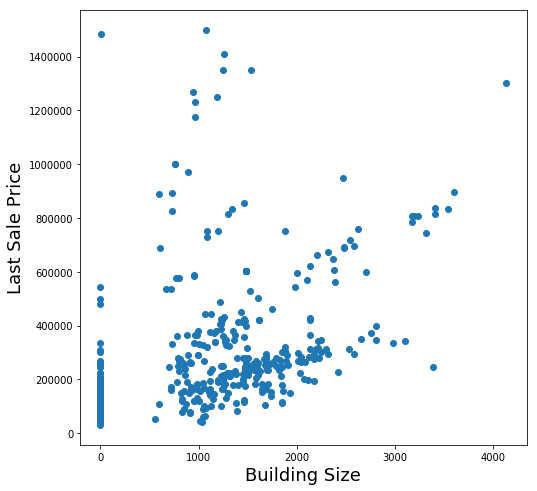

In [32]:
plt.figure(figsize=(8,8))
plt.scatter(df['building_size'], df['price'])
plt.xlabel('Building Size', fontsize=18)
plt.ylabel('Last Sale Price', fontsize=18)
plt.show()

And just in case we want to make sure we have the exact same dataset in the future, let's write it to a tab separated file.

In [36]:
df.to_csv('my_example_data.csv', sep='\t', index=False)